In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/framingham-heart-study/Framingham Dataset.csv
/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv
/kaggle/input/cardiovascular-disease-dataset/Cardiovascular_Disease_Dataset/Cardiovascular_Disease_Dataset.csv
/kaggle/input/cardiovascular-disease-dataset/Cardiovascular_Disease_Dataset/Cardiovascular_Disease_Dataset_Description.pdf


# **Predictive model that assesses the risk of cardiovascular disease based on indicators of diabetes and hypertension**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
diabetes_df = pd.read_csv('/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv')
framingham_df = pd.read_csv('/kaggle/input/framingham-heart-study/Framingham Dataset.csv')
cardio_df = pd.read_csv('/kaggle/input/cardiovascular-disease-dataset/Cardiovascular_Disease_Dataset/Cardiovascular_Disease_Dataset.csv')

In [5]:
unique_values = {col: diabetes_df[col].unique() for col in diabetes_df.columns}
print(unique_values)

{'gender': array(['Female', 'Male', 'Other'], dtype=object), 'age': array([80.  , 54.  , 28.  , 36.  , 76.  , 20.  , 44.  , 79.  , 42.  ,
       32.  , 53.  , 78.  , 67.  , 15.  , 37.  , 40.  ,  5.  , 69.  ,
       72.  ,  4.  , 30.  , 45.  , 43.  , 50.  , 41.  , 26.  , 34.  ,
       73.  , 77.  , 66.  , 29.  , 60.  , 38.  ,  3.  , 57.  , 74.  ,
       19.  , 46.  , 21.  , 59.  , 27.  , 13.  , 56.  ,  2.  ,  7.  ,
       11.  ,  6.  , 55.  ,  9.  , 62.  , 47.  , 12.  , 68.  , 75.  ,
       22.  , 58.  , 18.  , 24.  , 17.  , 25.  ,  0.08, 33.  , 16.  ,
       61.  , 31.  ,  8.  , 49.  , 39.  , 65.  , 14.  , 70.  ,  0.56,
       48.  , 51.  , 71.  ,  0.88, 64.  , 63.  , 52.  ,  0.16, 10.  ,
       35.  , 23.  ,  0.64,  1.16,  1.64,  0.72,  1.88,  1.32,  0.8 ,
        1.24,  1.  ,  1.8 ,  0.48,  1.56,  1.08,  0.24,  1.4 ,  0.4 ,
        0.32,  1.72,  1.48]), 'hypertension': array([0, 1]), 'heart_disease': array([1, 0]), 'smoking_history': array(['never', 'No Info', 'current', 'former', 'e

In [6]:
diabetes_df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [7]:
diabetes_df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [8]:
print(diabetes_df['diabetes'].value_counts())

diabetes
0    91500
1     8500
Name: count, dtype: int64


In [9]:
print(diabetes_df['smoking_history'].value_counts())

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64


In [10]:
#gender column
diabetes_df['gender']= diabetes_df['gender'].map({'Female':0,'Male':1,'Other':2}).fillna(2)
#smoking column
smoking_mapping={
    'never':'never',
    'current':'current',
    'former':'past',
    'not current':'past',
    'ever':'past',
    'No Info':'unknown'
}
diabetes_df['smoking_history']=diabetes_df['smoking_history'].replace(smoking_mapping)
# One-hot encode the smoking_history column
diabetes_df=pd.get_dummies(diabetes_df,columns=['smoking_history'],prefix='smoking',drop_first=True)
diabetes_df=diabetes_df.astype(int)
print(diabetes_df.filter(like='smoking_'))

       smoking_never  smoking_past  smoking_unknown
0                  1             0                0
1                  0             0                1
2                  1             0                0
3                  0             0                0
4                  0             0                0
...              ...           ...              ...
99995              0             0                1
99996              0             0                1
99997              0             1                0
99998              1             0                0
99999              0             0                0

[100000 rows x 3 columns]


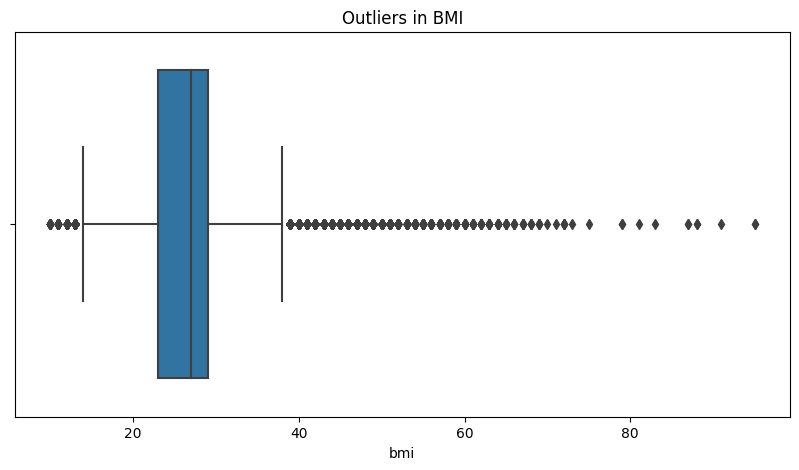

In [11]:
plt.figure(figsize=(10, 5))  # Correct parameter name is 'figsize', not 'figure'
sns.boxplot(data=diabetes_df, x='bmi')
plt.title("Outliers in BMI")
plt.show()
# Outliers clipping for bmi,HbA1c level, blood glucose level
for col in ['bmi','HbA1c_level','blood_glucose_level']:
    q1,q3=diabetes_df[col].quantile([0.25, 0.75]) 
    iqr=q3-q1  
    lower_bound=q1-1.5*iqr 
    upper_bound=q3+1.5*iqr 
    diabetes_df[col] = np.clip(diabetes_df[col], lower_bound, upper_bound)

<Axes: xlabel='bmi'>

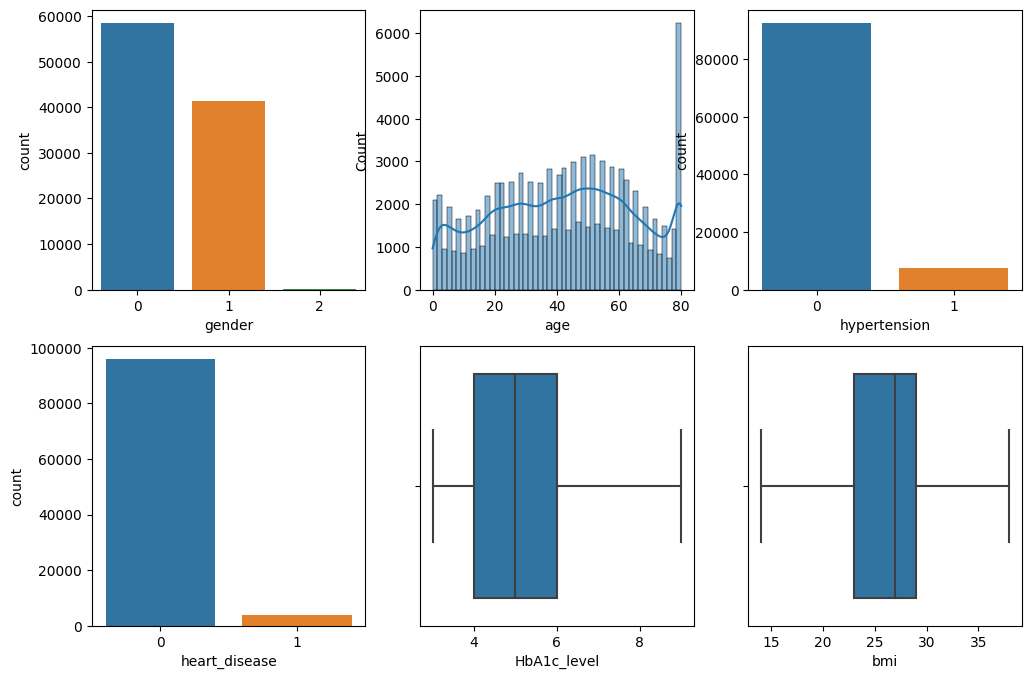

In [12]:
# Set up a grid for subplots
plt.figure(figsize=(12, 8))

# Plot for gender
plt.subplot(2, 3, 1)
sns.countplot(x='gender', data=diabetes_df)

# Plot for age
plt.subplot(2, 3, 2)
sns.histplot(diabetes_df['age'], kde=True)

# Plot for hypertension
plt.subplot(2, 3, 3)
sns.countplot(x='hypertension', data=diabetes_df)

# Plot for heart disease
plt.subplot(2, 3, 4)
sns.countplot(x='heart_disease', data=diabetes_df)

# Plot for HbA1c level
plt.subplot(2, 3, 5)
sns.boxplot(x=diabetes_df['HbA1c_level'])

plt.subplot(2,3,6)
sns.boxplot(data=diabetes_df,x='bmi')

# Exploratory Data Analysis (EDA)

In [13]:
diabetes_df=diabetes_df.dropna()

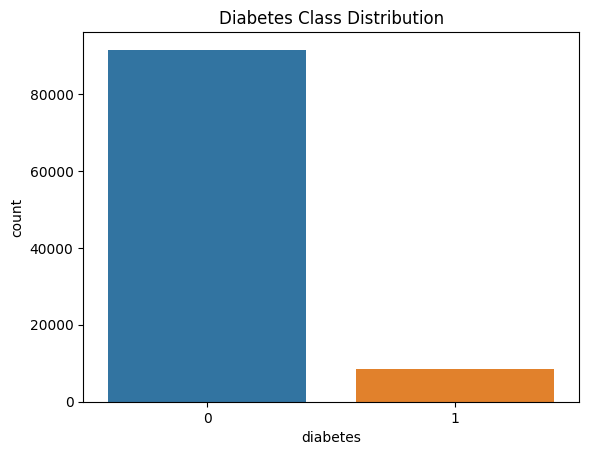

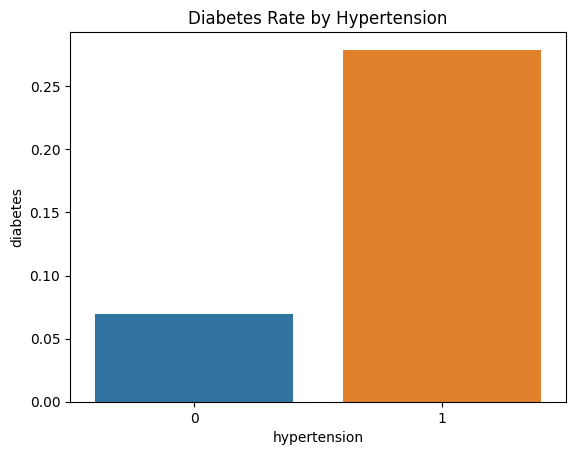

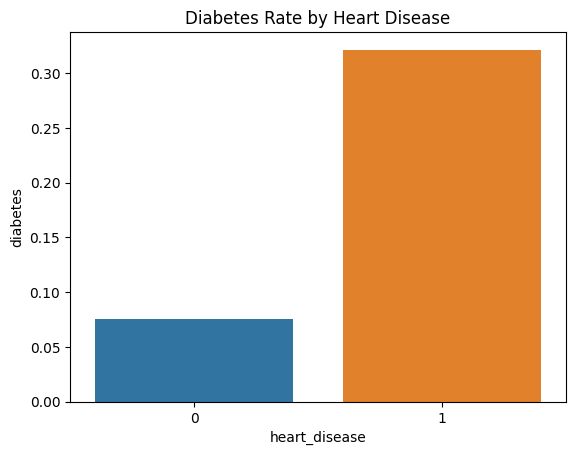

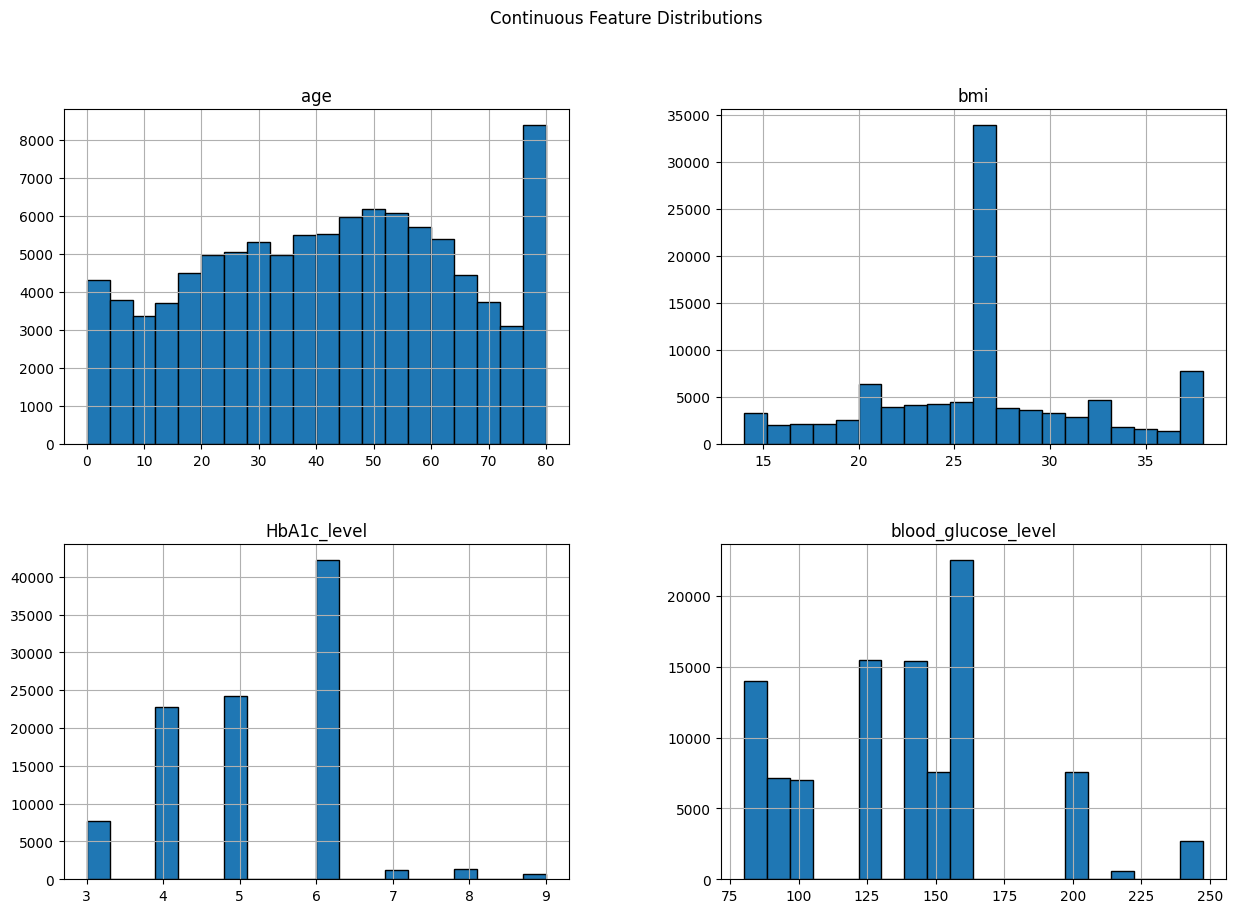

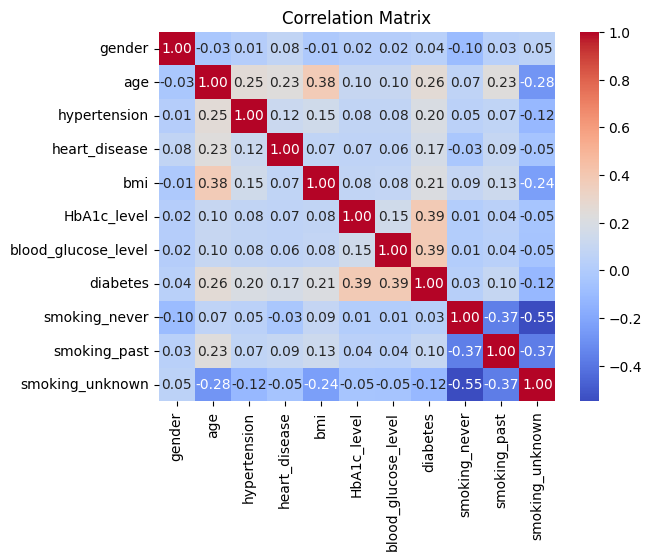

In [14]:
# Distribution of the target variable
sns.countplot(x='diabetes', data=diabetes_df)
plt.title("Diabetes Class Distribution")
plt.show()
#  Relationships of hypertension and heart_disease with diabetes
sns.barplot(x='hypertension', y='diabetes', data=diabetes_df, ci=None)
plt.title("Diabetes Rate by Hypertension")
plt.show()

sns.barplot(x='heart_disease', y='diabetes', data=diabetes_df, ci=None)
plt.title("Diabetes Rate by Heart Disease")
plt.show()

# 4. Distribution of continuous features
cont_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
diabetes_df[cont_features].hist(bins=20, figsize=(15, 10), edgecolor='black')
plt.suptitle("Continuous Feature Distributions")
plt.show()
# 2. Correlation matrix
sns.heatmap(diabetes_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


# Model Training

In [15]:
X_diabetes=diabetes_df.drop('diabetes',axis=1)
y_diabetes=diabetes_df['diabetes']
#SMOTE(Synthetic Minority Over-sampling Technique) for handling imbalance data
smote=SMOTE(random_state=42)
X_smote_diabetes,y_smote_diabetes=smote.fit_resample(X_diabetes,y_diabetes)

In [16]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(f"\n{model_name}:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    try:  # Handle models without predict_proba (like SVM with linear kernel)
        y_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
        print(f"ROC AUC: {roc_auc:.2f}")
    except AttributeError:
        print("ROC AUC not available for this model.")
    return y_pred



Logistic Regression:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     18300
           1       0.88      0.88      0.88     18300

    accuracy                           0.88     36600
   macro avg       0.88      0.88      0.88     36600
weighted avg       0.88      0.88      0.88     36600

Confusion Matrix:
 [[16179  2121]
 [ 2119 16181]]
ROC AUC: 0.96

Random Forest:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     18300
           1       0.95      0.97      0.96     18300

    accuracy                           0.96     36600
   macro avg       0.96      0.96      0.96     36600
weighted avg       0.96      0.96      0.96     36600

Confusion Matrix:
 [[17295  1005]
 [  588 17712]]
ROC AUC: 0.99


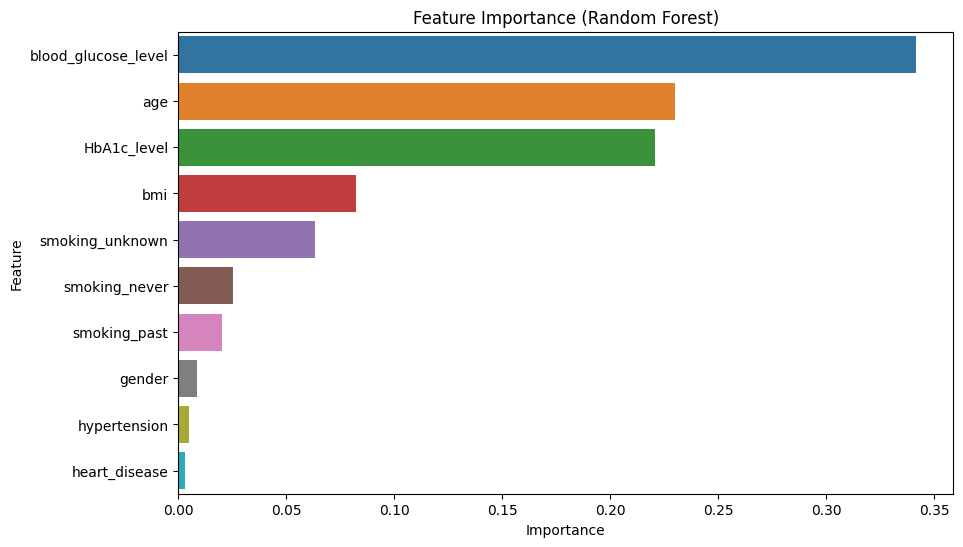

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report,roc_auc_score
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_smote_diabetes, y_smote_diabetes, test_size=0.2, random_state=42, stratify=y_smote_diabetes)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression Model
diabetes_predictions  = LogisticRegression(max_iter=1000, random_state=42)
diabetes_predictions .fit(X_train_scaled, y_train)
evaluate_model(diabetes_predictions , X_test_scaled, y_test, "Logistic Regression")

# Random Forest Model
diabetes_probabilities  = RandomForestClassifier(random_state=42, n_estimators=100)
diabetes_probabilities .fit(X_train, y_train)
evaluate_model(diabetes_probabilities , X_test, y_test, "Random Forest")

# Feature Importance from Random Forest
importances = pd.DataFrame({'Feature': X_diabetes.columns, 'Importance': diabetes_probabilities .feature_importances_})
importances.sort_values(by='Importance', ascending=False, inplace=True)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title("Feature Importance (Random Forest)")
plt.show()

# Framingham Dataset for Hypertension 

In [18]:
framingham_df.head()

,RANDID,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,CIGPDAY,BMI,DIABETES,...,CVD,HYPERTEN,TIMEAP,TIMEMI,TIMEMIFC,TIMECHD,TIMESTRK,TIMECVD,TIMEDTH,TIMEHYP
0,2448,1,195.0,39,106.0,70.0,0,0.0,26.97,0,...,1,0,8766,6438,6438,6438,8766,6438,8766,8766
1,2448,1,209.0,52,121.0,66.0,0,0.0,NaN,0,...,1,0,8766,6438,6438,6438,8766,6438,8766,8766
2,6238,2,250.0,46,121.0,81.0,0,0.0,28.73,0,...,0,0,8766,8766,8766,8766,8766,8766,8766,8766
3,6238,2,260.0,52,105.0,69.5,0,0.0,29.43,0,...,0,0,8766,8766,8766,8766,8766,8766,8766,8766
4,6238,2,237.0,58,108.0,66.0,0,0.0,28.50,0,...,0,0,8766,8766,8766,8766,8766,8766,8766,8766


In [19]:
framingham_df.isnull().sum()

RANDID         0
SEX            0
TOTCHOL      409
AGE            0
SYSBP          0
DIABP          0
CURSMOKE       0
CIGPDAY       79
BMI           52
DIABETES       0
BPMEDS       593
HEARTRTE       6
GLUCOSE     1440
educ         295
PREVCHD        0
PREVAP         0
PREVMI         0
PREVSTRK       0
PREVHYP        0
TIME           0
PERIOD         0
HDLC        8600
LDLC        8601
DEATH          0
ANGINA         0
HOSPMI         0
MI_FCHD        0
ANYCHD         0
STROKE         0
CVD            0
HYPERTEN       0
TIMEAP         0
TIMEMI         0
TIMEMIFC       0
TIMECHD        0
TIMESTRK       0
TIMECVD        0
TIMEDTH        0
TIMEHYP        0
dtype: int64

In [20]:
from sklearn.impute import KNNImputer
imputer=KNNImputer(n_neighbors=5)
framingham_df.iloc[:,:]=imputer.fit_transform(framingham_df)
framingham_df.drop(columns=['RANDID'], inplace=True, errors='ignore')

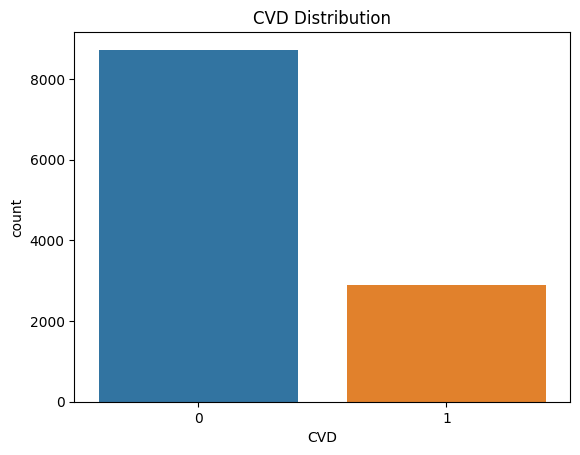

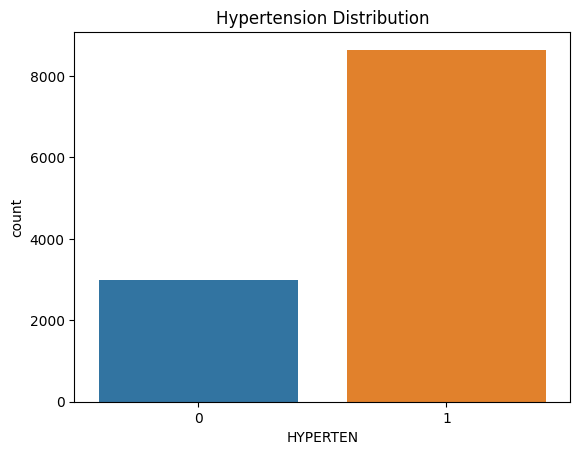

In [21]:
#CVD and Hypertension distribution
sns.countplot(data=framingham_df, x='CVD')
plt.title("CVD Distribution")
plt.show()

sns.countplot(data=framingham_df, x='HYPERTEN')
plt.title("Hypertension Distribution")
plt.show()


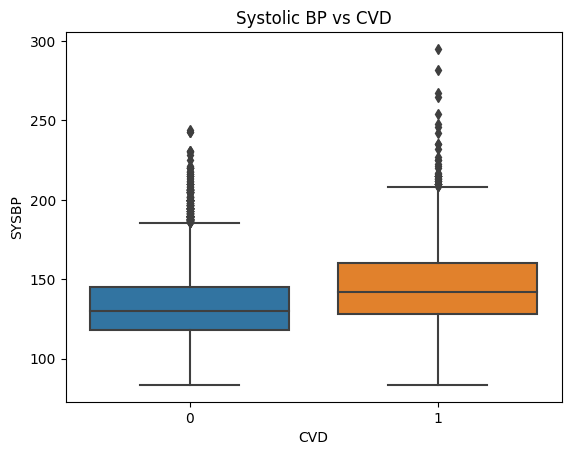

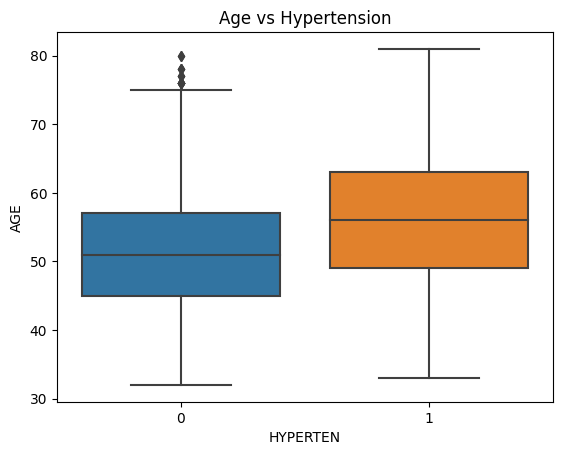

In [22]:
sns.boxplot(data=framingham_df, x='CVD', y='SYSBP')
plt.title("Systolic BP vs CVD")
plt.show()

sns.boxplot(data=framingham_df, x='HYPERTEN', y='AGE')
plt.title("Age vs Hypertension")
plt.show()

In [23]:
# CVD Prediction
X_cvd_fram = framingham_df.drop(['CVD', 'HYPERTEN'], axis=1)
y_cvd_fram = framingham_df['CVD']

# Hypertension Prediction
X_hyp_fram = framingham_df.drop(['CVD', 'HYPERTEN'], axis=1)
y_hyp_fram = framingham_df['HYPERTEN']

In [24]:
# Split data
X_train_cvd, X_test_cvd, y_train_cvd, y_test_cvd = train_test_split(X_cvd_fram, y_cvd_fram, test_size=0.2, random_state=42, stratify=y_cvd_fram)

# Random Forest for CVD
rf_cvd = RandomForestClassifier(random_state=42)
rf_cvd.fit(X_train_cvd, y_train_cvd)
y_pred_cvd = rf_cvd.predict(X_test_cvd)
print("Random Forest - CVD Prediction")
print(classification_report(y_test_cvd, y_pred_cvd))


Random Forest - CVD Prediction
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1746
           1       1.00      1.00      1.00       580

    accuracy                           1.00      2326
   macro avg       1.00      1.00      1.00      2326
weighted avg       1.00      1.00      1.00      2326



In [25]:
cardio_df.head()

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,103368,53,1,2,171,0,0,1,147,0,5.3,3,3,1
1,119250,40,1,0,94,229,0,1,115,0,3.7,1,1,0
2,119372,49,1,2,133,142,0,0,202,1,5.0,1,0,0
3,132514,43,1,0,138,295,1,1,153,0,3.2,2,2,1
4,146211,31,1,1,199,0,0,2,136,0,5.3,3,2,1


In [26]:
cardio_df.drop(columns=['patientid'], inplace=True)

In [27]:
cardio_df.shape

(1000, 13)

In [28]:
# X_cvd_cardio = X_cvd_cardio.dropna()
# y_cvd_cardio = y_cvd_cardio[X_cvd_cardio.index]

In [29]:
cardio_df.isnull().sum()

age                  0
gender               0
chestpain            0
restingBP            0
serumcholestrol      0
fastingbloodsugar    0
restingrelectro      0
maxheartrate         0
exerciseangia        0
oldpeak              0
slope                0
noofmajorvessels     0
target               0
dtype: int64

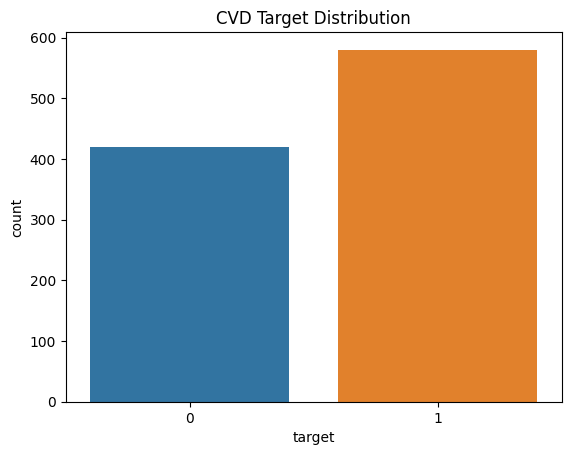

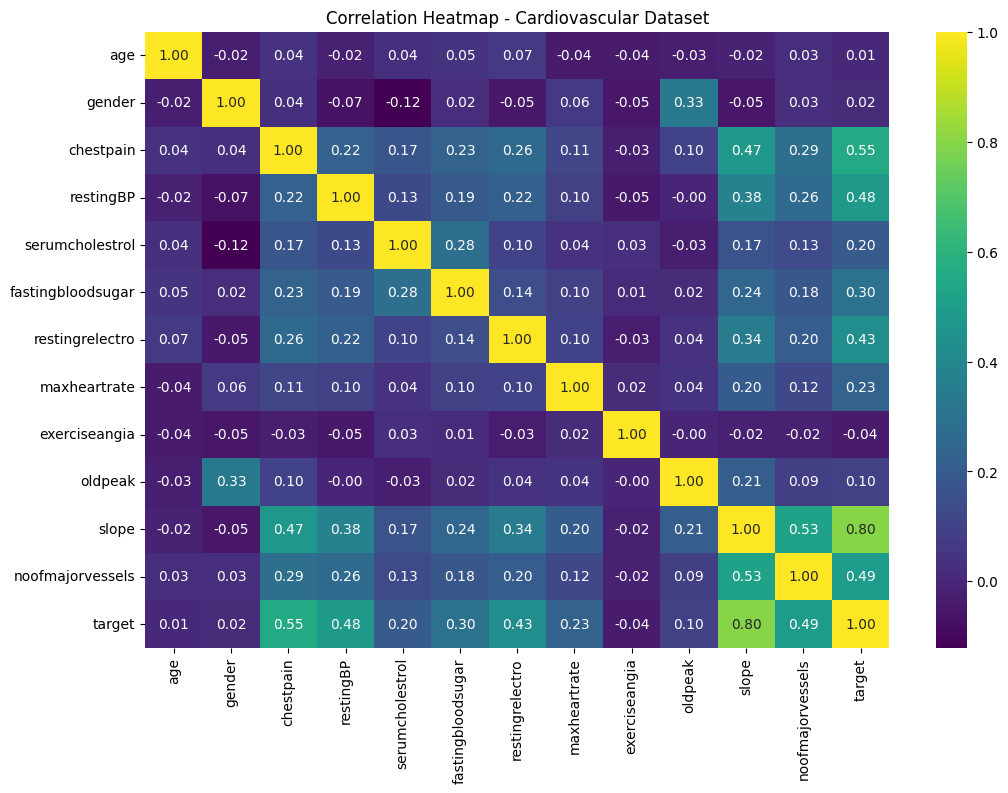

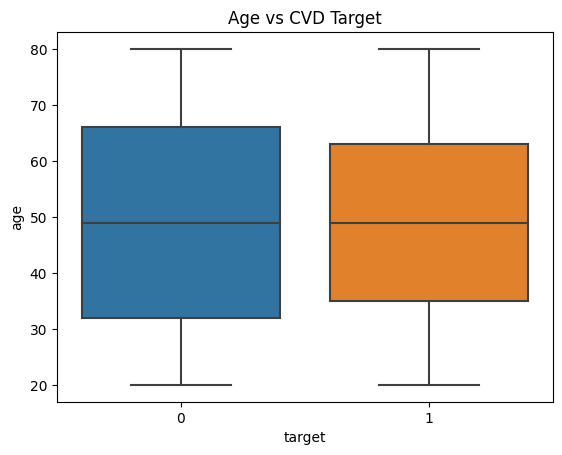

In [30]:
#CVD distribution in target
sns.countplot(data=cardio_df, x='target')
plt.title("CVD Target Distribution")
plt.show()
#correlation matrix to analyse relationships between predictors.
plt.figure(figsize=(12, 8))
sns.heatmap(cardio_df.corr(), annot=True, fmt='.2f', cmap='viridis')
plt.title("Correlation Heatmap - Cardiovascular Dataset")
plt.show()
#Feature analysis of features like age, cholesterol vs. target
sns.boxplot(data=cardio_df, x='target', y='age')
plt.title("Age vs CVD Target")
plt.show()


In [31]:
X_cvd_cardio = cardio_df.drop('target', axis=1)
y_cvd_cardio = cardio_df['target']

In [32]:
print(X_cvd_cardio.shape)
print(y_cvd_cardio.shape)

(1000, 12)
(1000,)


In [33]:
# Split the data
X_train_cardio, X_test_cardio, y_train_cardio, y_test_cardio = train_test_split(X_cvd_cardio, y_cvd_cardio, test_size=0.2, random_state=42)
print(X_train_cardio.shape, y_test_cardio.shape)

(800, 12) (200,)


In [34]:
#Model for CVD
X_cvd_cardio = cardio_df.drop(['target'], axis=1)
y_cvd_cardio = cardio_df['target']

X_train_cardio, X_test_cardio, y_train_cardio, y_test_cardio = train_test_split(X_cvd_cardio, y_cvd_cardio, test_size=0.2, random_state=42)

rf_cardio = RandomForestClassifier(random_state=42)
rf_cardio.fit(X_train_cardio, y_train_cardio)
y_pred_cardio = rf_cardio.predict(X_test_cardio)
print("Random Forest - Cardiovascular Dataset")
print(classification_report(y_test_cardio, y_pred_cardio))


Random Forest - Cardiovascular Dataset
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        83
           1       0.98      1.00      0.99       117

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



In [35]:
# Assuming `diabetes_predictions` from the diabetes model
framingham_df['predicted_diabetes'] = diabetes_predictions
cardio_df['predicted_diabetes'] = diabetes_predictions
